In [3]:
#<GRADED>
import numpy as np
#</GRADED>
import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import sys
from scipy.io import loadmat
import time

%matplotlib inline

In [8]:
# tokenize the email and hashes the symbols into a vector
def extractfeaturesnaive(path, B):
    with open(path, 'r') as femail:
        # initialize all-zeros feature vector
        v = np.zeros(B)
        email = femail.read()
        # breaks for non-ascii characters
        tokens = email.split()
        for token in tokens:
            v[hash(token) % B] = 1
    return v

def loadspamdata(extractfeatures, B=512, path="./data_train/"):
    '''
    INPUT:
    extractfeatures : function to extract features
    B               : dimensionality of feature space
    path            : the path of folder to be processed
    
    OUTPUT:
    X, Y
    '''
    if path[-1] != '/':
        path += '/'
    
    xs = np.zeros((2,B))
    ys = np.zeros(2)
    """
    ham easy_ham/01750.73b4d9ab83de83ae58707c8bdcda0fc5
    """
    label = 'ham'
    ys[0] = (label == 'spam') * 2-1
    xs[0, :] = extractfeatures(path+"01750.73b4d9ab83de83ae58707c8bdcda0fc5",B)
    
    """
    spam spam_2/00026.c62c9f08db4ee1b99626dbae575008fe
    """
    label = 'spam'
    ys[1] = (label == 'spam') * 2-1
    xs[1, :] = extractfeatures(path+"01750.73b4d9ab83de83ae58707c8bdcda0fc5",B)
    
    print('Loaded %d input emails.' % len(ys))
    return xs, ys

X,Y = loadspamdata(extractfeaturesnaive)
X.shape

Loaded 2 input emails.


(2, 512)

In [9]:
# Split data into training and validation
n, d = X.shape
cutoff = int(np.ceil(0.8 * n))
# indices of training samples
xTr = X[:cutoff,:]
yTr = Y[:cutoff]
# indices of testing samples
xTv = X[cutoff:,:]
yTv = Y[cutoff:]

In [11]:
"""
We use Adagrad gradient descent algorithm, but with various loss functions. 
Implement the function ridge which computes the ridge 
regression loss and gradient for a particular data set xTr, yTr and a weight vector w, and 
regularization constant lambda
"""
def ridge(w, xTr, yTr, lmbda):
    """
    INPUT:
    w     : d-dimensional weight vector (d,)
    xTr   : nxd dimensional matrix (each row is an input vector) (n, d)
    yTr   : n-dimensional vector (each entry is a label) (n,)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d-dimensional gradient at w (d,)
    """
    n, d = xTr.shape
    
    # Calculate the predicted values
    predicted_values = np.dot(xTr, w)  # Shape: (n,)
    
    # Calculate the errors
    errors = predicted_values - yTr  # Shape: (n,)
    
    # Calculate the OLS Loss
    ols_loss = (1 / n) * np.sum(errors ** 2)
    
    # Calculate the L2 Regularization Term
    l2_distance = np.dot(w, w)
    l2_regularization = lmbda * l2_distance
    
    # Calculate the total ridge regression loss
    loss = ols_loss + l2_regularization
    
    # Calculate the gradient
    grad = (1 / n) * 2 * np.dot(xTr.T, errors) + 2 * lmbda * w
    
    return loss, grad


The norm ratio is 0.0000000003.


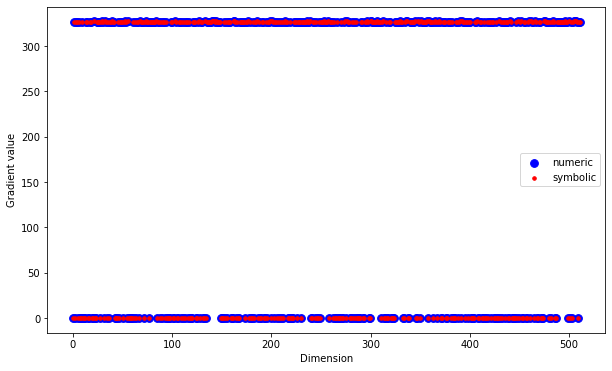

In [12]:
"""
Derive gradient numerically to test against
"""

def numericalgradient(fun,w,e):
    # get dimensionality
    d = len(w)
    # initialize numerical derivative
    dh = np.zeros(d)
    # go through dimensions
    for i in range(d):
        # copy the weight vector
        nw = w.copy()
        # perturb dimension i
        nw[i] += e
        # compute loss
        l1, temp = fun(nw)
        # perturb dimension i again
        nw[i] -= 2*e
        # compute loss
        l2, temp = fun(nw)
        # the gradient is the slope of the loss
        dh[i] = (l1 - l2) / (2*e)
    return dh

def checkgrad(fun,w,e):
    # evaluate symbolic gradient from fun()
    loss,dy = fun(w)
    # estimate gradient numerically from fun()
    dh = numericalgradient(fun,w,e)
    
    # ii = dy.argsort()
    ii = np.array([i for i in range(len(dy))])
    
    plt.figure(figsize=(10,6))
    plt.scatter([i for i in range(len(dy))], dh[ii], c='b', marker='o', s=60)
    plt.scatter([i for i in range(len(dy))], dy[ii], c='r', marker='.', s=50)
    plt.xlabel('Dimension')
    plt.ylabel('Gradient value')
    plt.legend(["numeric","symbolic"])
    
    # return the norm of the difference scaled by the norm of the sum
    return np.linalg.norm(dh - dy) / np.linalg.norm(dh + dy)

# set lmbda (λ) arbitrarily
lmbda = 0.1
# dimensionality of the input
_, d = xTr.shape
# evaluate loss on random vector
w = np.random.rand(d)
# the lambda function notation is an inline way to define a function with only a single argument.
ratio = checkgrad(lambda weight: ridge(weight,xTr,yTr,lmbda),w,1e-05)
print("The norm ratio is %.10f." % ratio)

In [13]:
"""
Perform adaptive gradient descent. 
"""
def adagrad(func,w,alpha,maxiter,eps,delta=1e-02):
    """
    INPUT:
    func    : function to minimize
              (loss, gradient = func(w))
    w       : d dimensional initial weight vector (d,)
    alpha   : initial gradient descent stepsize (scalar)
    maxiter : maximum amount of iterations (scalar)
    eps     : epsilon value (scalar)
    delta   : if norm(gradient) < delta, it quits (scalar)
    
    OUTPUTS:
     
    w      : d dimensional final weight vector (d,)
    losses : vector containing loss at each iteration
    
    Note   : do not include both the stopping conditions (maxiter and delta) in the loop conditional.
    """
    
    losses = np.zeros(maxiter)
    g_sq = np.zeros(w.shape)  # Initialize the squared gradient accumulator
    
    for t in range(maxiter):
        loss, gradient = func(w)
        losses[t] = loss
        
        if np.linalg.norm(gradient) < delta:
            break
        
        g_sq += gradient ** 2  # Accumulate the squared gradient
        
        adjusted_alpha = alpha / (np.sqrt(g_sq) + eps)
        w -= adjusted_alpha * gradient
    
    return w, losses

Final loss: 2.133831


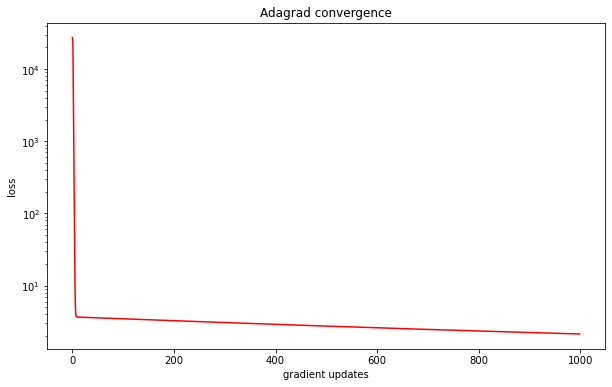

In [14]:
"""
Test script
"""
_, d = xTr.shape
eps = 1e-06
w, losses = adagrad(lambda weight: ridge(weight, xTr, yTr, lmbda), np.random.rand(d), 1, 1000, eps)

plt.figure(figsize=(10,6))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("gradient updates")
plt.ylabel("loss")
plt.title("Adagrad convergence")
print("Final loss: %f" % losses[-1])

In [16]:
"""
Linear classifier (taken from previous project)
"""
def linclassify(w,xTr):
    ## fill in your code here
    raw_scores = np.dot(xTr, w)
    
    # If the raw score is greater than or equal to 0, classify as 1, else as -1
    preds = np.where(raw_scores >= 0, 1, -1)
    
    return preds

"""
Test script
"""
# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

Training accuracy 50.00%
Validation accuracy nan%



In [18]:
"""
Now implement with logistic loss function instead of ridge
"""
def logistic(w,xTr,yTr):
    """
    INPUT:
    w     : d   dimensional weight vector (d,)
    xTr   : nxd dimensional matrix (each row is an input vector) (n,d)
    yTr   : n   dimensional vector (each entry is a label) (n,)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w (d,)
    """
    n, d = xTr.shape
    
    # Calculate the raw scores for each data point
    raw_scores = np.dot(xTr, w)
    
    # Calculate the logistic loss
    loss = np.sum(np.log(1 + np.exp(-yTr * raw_scores)))
    
    # Calculate the gradient of the logistic loss without using sigmoid
    exp_term = np.exp(-yTr * raw_scores)
    gradient = -np.dot(xTr.T, (yTr * exp_term) / (1 + exp_term))
    
    return loss, gradient

In [19]:
"""
Now hinge loss
"""
def hinge(w, xTr, yTr, lmbda):
    """
    INPUT:
    w     : d-dimensional weight vector (d,)
    xTr   : nxd dimensional matrix (each row is an input vector) (n, d)
    yTr   : n-dimensional vector (each entry is a label: +1 or -1) (n,)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d-dimensional gradient at w (d,)
    """
    n, d = xTr.shape
    
    # Calculate the raw scores for each data point
    raw_scores = np.dot(xTr, w)
    
    # Calculate the hinge loss for each data point
    hinge_loss = np.maximum(0, 1 - yTr * raw_scores)
    
    # Calculate the total hinge loss with regularization
    loss = np.sum(hinge_loss) + lmbda * np.dot(w, w)
    
    # Calculate the gradient of the hinge loss with regularization
    mask = yTr * raw_scores < 1
    gradient = np.zeros(d)
    gradient = -np.dot(xTr.T, yTr * mask) + 2 * lmbda * w
    
    return loss, gradient